# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [34]:
portfolio.head()


,difficulty,duration,id,offer_type,reward,eamil,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,0,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,0


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
portfolio['channels'].value_counts

<bound method IndexOpsMixin.value_counts of 0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object>

In [5]:
for value in ['eamil', 'web', 'mobile', 'social']:
    portfolio[value] = portfolio['channels'].apply(lambda x: 1 if value in x else 0)
portfolio.drop('channels', axis=1, inplace=True)
portfolio.head()

,difficulty,duration,id,offer_type,reward,eamil,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,0,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,0


In [6]:
#Now profile!
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
import datetime

profile['year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)
print(profile.head())

   age gender                                id    income  year  month  day  \
0  118   None  68be06ca386d4c31939f3a4f0e3dd783       NaN  2017      2   12   
1   55      F  0610b486422d4921ae7d2bf64640c50b  112000.0  2017      7   15   
2  118   None  38fe809add3b4fcf9315a9694bb96ff5       NaN  2018      7   12   
3   75      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0  2017      5    9   
4  118   None  a03223e636434f42ac4c3df47e8bac43       NaN  2017      8    4   

        date  
0 2017-02-12  
1 2017-07-15  
2 2018-07-12  
3 2017-05-09  
4 2017-08-04  


In [8]:
#transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
transcript['type'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])
print(transcript.type.value_counts())

amount      138953
offer id    134002
offer_id     33579
Name: type, dtype: int64


In [10]:
transcript.head()

,event,person,time,value,type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


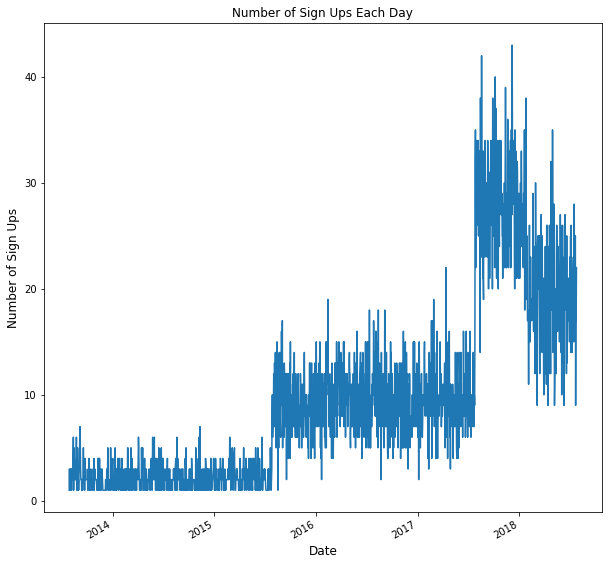

In [11]:
##PLOTTING
import matplotlib.pyplot as plt
profile.date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

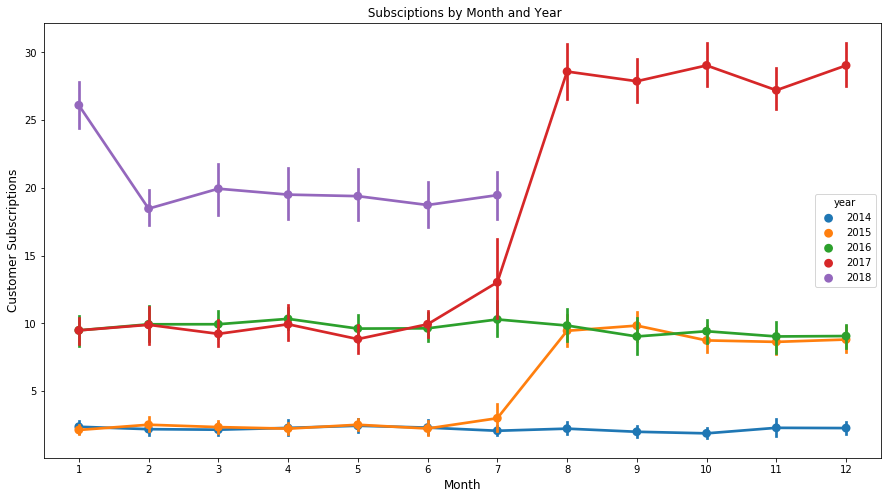

In [35]:
#Customer Subscriptions 
import seaborn as sns
membership_subs = profile[profile['year'] >= 2014].groupby(['year','month','day'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="month", y="id", hue="year", data = membership_subs)
plt.ylabel('Customer Subscriptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title(' Subsciptions by Month and Year');

In [13]:
df2 = pd.read_json(r'data/profile.json',lines=True)


In [14]:
### People with less income Still love StarBucks!

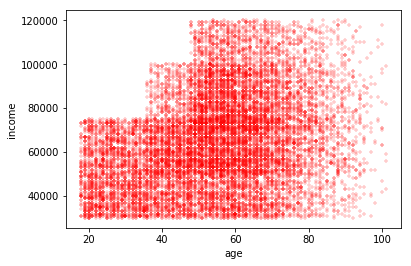

In [15]:
df2.plot(kind='scatter',x='age',y='income',color='red',alpha=0.2, marker='+')
plt.show()

In [16]:
# removing 'O' from gender as well as NaN values
zz = df2[df2.gender != 'O']
zz.gender.value_counts()
zz.columns
zz=zz[zz['gender'].notna()]

gender
F    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

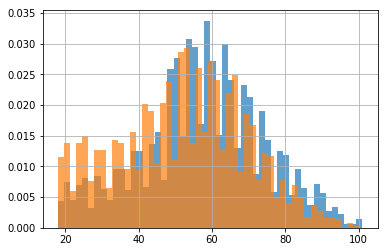

In [17]:
zz.groupby('gender').age.hist(alpha=0.7,bins=50,density = True)

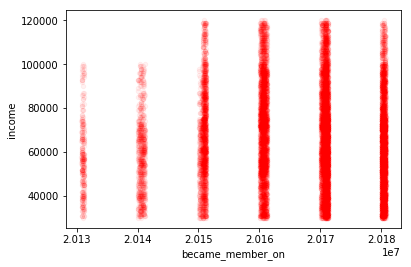

In [18]:
### Starbucks started selling more coffee in 2017  as compared to 2013
df2.plot(kind='scatter',x='became_member_on',y='income',color='red',alpha=0.05)
plt.show()

In [19]:
df4 = pd.read_json('data/transcript.json', orient='records', lines=True)
df4.columns

df4.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [20]:
df2 = pd.read_json(r'data/profile.json',lines=True)
df2.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [21]:
df4['id'] = df4['person'] 

In [22]:
s1 = pd.merge(df2, df4, how='inner', on=['id'])


In [23]:
s1.head()

,age,became_member_on,gender,id,income,event,person,time,value
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,offer received,68be06ca386d4c31939f3a4f0e3dd783,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,offer received,68be06ca386d4c31939f3a4f0e3dd783,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,transaction,68be06ca386d4c31939f3a4f0e3dd783,360,{'amount': 0.35000000000000003}


In [24]:
s1.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [25]:
# removing 'O' from gender as well as NaN values
s2 = s1[s1.gender != 'O']
s2.gender.value_counts()
s2=s2[s2['gender'].notna()]
s2.gender.value_counts()

M    155690
F    113101
Name: gender, dtype: int64

In [26]:
ff = s2[s2.event=='offer viewed']

In [27]:
s2.head()

,age,became_member_on,gender,id,income,event,person,time,value
21,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,18,{'amount': 21.51}
22,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,144,{'amount': 32.28}
23,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
24,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,504,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
25,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,528,{'amount': 23.22}


event
offer received    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

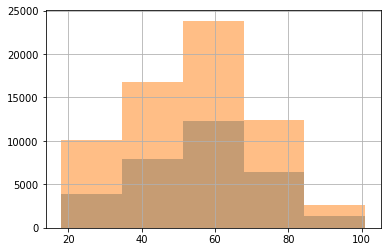

In [28]:

s2.groupby(s2.event[s2.event=='offer completed']).age.hist(bins=5,alpha=0.5)
s2.groupby(s2.event[s2.event=='offer received']).age.hist(bins=5,alpha=0.5)


event
offer received    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

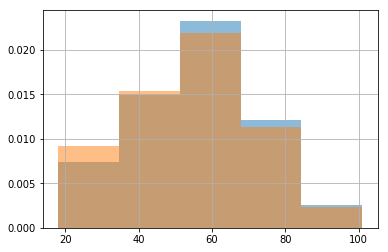

In [29]:
s2.groupby(s2.event[s2.event=='offer completed']).age.hist(bins=5,density = True,alpha=0.5)
s2.groupby(s2.event[s2.event=='offer received']).age.hist(bins=5,density = True,alpha=0.5)


event
offer viewed    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

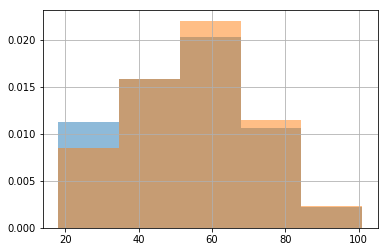

In [30]:
s2.groupby(s2.event[s2.event=='transaction']).age.hist(bins=5,density = True,alpha=0.5)
s2.groupby(s2.event[s2.event=='offer viewed']).age.hist(bins=5,density = True,alpha=0.5)